# Homework 3: Variational Autoencoder <10 points in total>


## Introduction
In this homework, we will try to implement a **variational autoencoder**. Given a dataset, a variational autoencoder tries to learn the distribution of the dataset itself. We will again test our model on peripheral blood mononuclear cells (PBMCs) single-cell gene expression dataset from the last assignment.

**You may find this material useful for your implementation**: 

* Slides of Lecture 12 (dim reduction) and Lecture 18 (variant effect prediction)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)


## What needs to be done-

#### Task 1. Complete the code for `encoder` and `decoder` 

#### Task 2. Complete the code for `VAE`

We will grade this problem based on the visualization plot. The classes in the plot should be more seperated than the ones in the plot of an untrained model from the autoencoder problem in the last homework. 



##### <font color='Red'>For this programming problem, you only need to submit the code (notebook with the output displayed) on gradescope. You don't need to write anything on the assignment PDF file</font>


## Environment

To run this code, you may have to install `numpy`, `torch`, `sckikit-learn`, `pandas`, and `matplotlib`, if you haven't done so and are running locally.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Read in the data
First, let's read in the PBMCs data that we will use for the training. 


In [ ]:
!wget https://dl.dropbox.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1 -O counts_PBMC.csv
!wget https://dl.dropbox.com/s/2p60xhx5x7theex/celltypes_PBMC.txt?dl=1 -O celltypes_PBMC.txt

--2023-04-06 18:05:21--  https://dl.dropbox.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1 [following]
--2023-04-06 18:05:21--  https://dl.dropboxusercontent.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39954243 (38M) [text/csv]
Saving to: ‘counts_PBMC.csv’

counts_PBMC.csv     100%[===================>]  38.10M  70.7MB/s    in 0.5s    

2023-04-06 18:05:22 (70.7 MB/s) - ‘counts_PBMC.csv’ saved [39954243/39954243]

--2023-04-06 18:05:23--  ht

In [ ]:
# Please don't change this cell.

expr_ctrl = pd.read_csv("counts_PBMC.csv", sep = ",", index_col = 0).values
anno_ctrl = pd.read_csv("celltypes_PBMC.txt", sep = "\t", header = None)
expr_ctrl = StandardScaler().fit_transform(expr_ctrl)

# Here we first reduce the dimension with PCA to speed up the training process
expr_ctrl = PCA(n_components = 100).fit_transform(expr_ctrl)
expr_ctrl = torch.FloatTensor(expr_ctrl)

In [ ]:
expr_ctrl.shape

torch.Size([3000, 100])

## Task 1: Implementing the encoder and the decoder of VAE

Variational autoencoder assumes that for each high-dimensional data $X$, there exist a low dimensional latent variable $Z$ that helps generate data similar to $X$. The distribution $P(Z|X,\theta)$ can be estimated using an encoder structure. The posterior distribution $P(Z|X,\theta)$ is assumed to be Gaussian:

\begin{equation}
P(Z|X,\theta) = \mathcal{N}(f_\mu(X,\theta_1), f_\sigma(X,\theta_2)\mathbf{I})
\end{equation}
where $f_\mu(z,\theta_1)$ and $f_\sigma(z,\theta_2)$ are modeled with neural network.

## Encoder
Now let's implement the encoder part. Here we use two two-layer fully connected neural networks to model $f_\mu(X,\theta_1)$ and $f_\sigma(X,\theta_2)$. We assume the first layer of $f_\mu(X,\theta_1)$ and $f_\sigma(X,\theta_2)$ are shared (`self.lin1`), and the last layer is different for those two functions (`self.fc_mu` for $f_\mu(X,\theta_1)$ and `self.fc_logvar` for $f_\sigma(X,\theta_2)$). Assume the dimension of $\mu_Z$ and $\sigma_Z$(output of the encoder) are $2$. Feel free to try different dimensions for the other layers. You can also add more layers if you like. 

Since the output of the neurons are not restricted to non-negative values, we predict log variance instead of variance. We can restore it back to  variance later.

In [ ]:
class encoder(nn.Module):
  def __init__(self, in_features, out_features):
    super(encoder, self).__init__()
    # TODO:complete the code
    # We'd recommend you to use nn.Linear() function in pytorch.
    self.lin1 = nn.Linear(in_features, 128)
    self.fc_mu = nn.Linear(128, out_features) #mean
    self.fc_logvar = nn.Linear(128, out_features) #log variance

  def forward(self, x):
    # TODO:complete the code. 
    # There should be no activation function for the output. 

    x = F.relu(self.lin1(x))
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)

    return x_mu, x_logvar

## Decoder
The decoder models $P(X|Z)$. We assume that $P(X|Z) = \mathcal{N}(f_{de}(z), \sigma \mathbf{I})$, and the decoder models $f_{de}(z)$ with two fully connected layers, `self.lin1` and `self.lin2`. Feel free to try different dimensions for the layers, but please make sure the input dimension is equal to the dimension of $Z$ and the output dimension is equal to the dimension of $X$. You can also add more layers if you like.

In [ ]:
class decoder(nn.Module):
  def __init__(self, in_features, out_features):
    super(decoder, self).__init__()
    # TODO: complete the code
    self.lin1 = nn.Linear(in_features,64)
    self.lin2 = nn.Linear(64, out_features)

  def forward(self, x):
    # TODO: complete the code
    # There should be no activation function for the output.     
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    return x

## Task2: Implementing VAE
After implementing the encoder and decoder, let's assemble them into a VAE. 

VAE estimates the parameters within the encoder and decoder by maximizing the expectation of log likelihood function:


\begin{equation}
\begin{aligned}
\hat{\theta} &= \arg\max_{\theta} \int P(Z,\theta)\log P(X|Z, \theta)dZ\\
&= \arg\max_{\theta} \mathbb{E}_{Z\sim P(Z,\theta)}[\log P(X|Z, \theta)]
\end{aligned}
\end{equation}


But the calculation is intractable. VAE instead finds a lower bound (ELBO-Evidence Lower Bound) of the log likelihood and try to maximize it (see the slides of the dimentionality reduction lecture).

We can then derive the loss function based on ELBO:


\begin{equation}
\begin{aligned}
{Loss} &= - \mathbb{E}_{q}[\log P(X|Z, \theta)] + \beta {D}_{KL}(Q(Z|X) || P(Z|X))
\end{aligned}
\end{equation}
where $\beta$ is a regularization coefficient.
The first term can encourage the reconstructed output to be consistent with the input, and the second forces the latent space to be Gaussian.



Assuming the distribution $P(X|{Z}, \theta)$ to be Gaussian, optimizing the first term in the above loss function can be reduced to minimizing the mean square error between input $X$ and reconstructed $\hat{X}$. 
\begin{equation}
\begin{aligned}
{Loss} &= {reconstruction \ error} + \beta \ {[KL \ error]}
\end{aligned}
\end{equation}



*  Here, we use Mean Square Error to calculate the reconstruction error. 
*  To implement KL divergence, you can refer to this post:
https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048











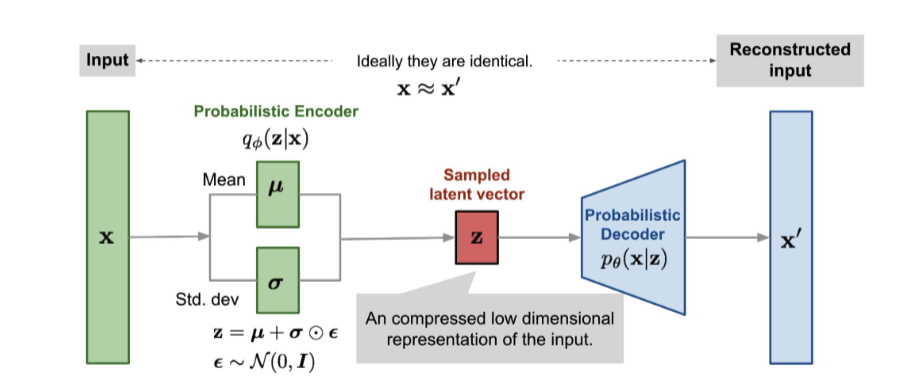





You will need to:

* **Initialize the VAE model**: Complete `__init__` function, declare encoder and decoder using the classes we defined above.
* **Sampling process**: Complete `latent_sample` function, sample `z` from the output of encoder. VAE uses reparameterization trick for the sampling process.
* **Loss function**: There are two parts in the loss function: one is the mse loss between input data and output result, the other is the kl divergence.
* **forward pass**: the `forward` function in `variational_autoencoder`.

In [ ]:
class variational_autoencoder(nn.Module): 
  def __init__(self, in_features, latent_dims = 2):
    super(variational_autoencoder,self).__init__()
    #TODO: complete the code to initialize the encoder and the decoder
    # encoder
    self.enc = encoder(in_features, latent_dims)
    # decoder
    self.dec = decoder(latent_dims, in_features)

  def forward(self,x):
    #TODO: complete the forward funciton
    # encoder
    x_mu, x_logvar = self.enc(x)
    # latent z sampling
    std = torch.exp(0.5 * x_logvar)
    eps = torch.randn_like(std)
    latent_z = eps * std + x_mu
    # decoder
    x = self.dec(latent_z)
    return x, x_mu, x_logvar
  
  def latent_sample(self, mu, logvar):
    #TODO: Sample the latent vector using the reparameterization trick
    # reparameterization, z = mu + std * N(0,I) 
    if self.training:
      # z ~ N(mu, std^2I), note that std should be positive, 
      # logvar can be negative as the output of linear layer, you may consider using exponential function to obtain standard deviation
      std = torch.exp(0.5 * logvar) #standard deviation
      eps = torch.randn_like(std) #error term   ##same shape with std, but is ~ N(0,1)
      z = eps * std + mu
      return z
    # evaluation 
    else:
      return mu
  
def MSE_KL(input, target, mu, logvar, beta):
  #TODO: Calculate the loss function 
  # mse is the mean square error between input and output
  mse = F.mse_loss(input, target, reduction = 'mean')
  # kl is the kl-divergence loss
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  # beta is the regularization value
  return mse + beta * kl

In [ ]:
####################Please don't change this cell.##############################

def train_model(model, optimizer, n_epochs=10, beta = 0.001):

    batch_size=256
    losses = []

    # we'll train the network for 10 epochs
    step = 0
    for epoch in range(n_epochs):
        # randomize the order of the data each time through
        random_order = np.random.permutation(expr_ctrl.shape[0])
        data_randomized = expr_ctrl[random_order]

        # train the network on batches of size `batch_size`
        for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
            step += 1

            # update the network weights to minimize the loss
            output, x_mu, x_logvar = model(data_batch)

            # get loss
            loss = MSE_KL(input = data_batch, target = output, mu = x_mu, logvar = x_logvar, beta = beta)

            # print the loss every 100 epochs
            if step % 100 == 0:
                print("Step: {} Loss: {:.3f}".format(step, loss.item()))

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
            losses.append(loss)

    return losses

####################Please don't change this cell.##############################

In [ ]:
# TODO: Please try with different learning rates and find the one that is suitable for our task. You can also change n_epochs or the optimizer

ae = variational_autoencoder(in_features = expr_ctrl.shape[1])
# training mode
ae.train()

# Learning rate for the optimizer is a key hyperparameter to play around with when we need to train the model.
learning_rate = 0.001
optimizer = optim.Adam(ae.parameters(),
                       lr=learning_rate)
losses = train_model(ae, optimizer = optimizer, n_epochs = 200)

Step: 100 Loss: 5.269
Step: 200 Loss: 5.785
Step: 300 Loss: 4.771
Step: 400 Loss: 5.152
Step: 500 Loss: 4.907
Step: 600 Loss: 5.704
Step: 700 Loss: 5.217
Step: 800 Loss: 5.896
Step: 900 Loss: 4.206
Step: 1000 Loss: 5.311
Step: 1100 Loss: 5.984
Step: 1200 Loss: 5.475
Step: 1300 Loss: 5.329
Step: 1400 Loss: 5.977
Step: 1500 Loss: 4.825
Step: 1600 Loss: 5.038
Step: 1700 Loss: 4.981
Step: 1800 Loss: 6.060
Step: 1900 Loss: 5.176
Step: 2000 Loss: 5.601
Step: 2100 Loss: 4.623
Step: 2200 Loss: 4.937


In [ ]:
####################Please don't change this cell.##############################

def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)
####################Please don't change this cell.##############################



## Visualization
After training the model, let's visualize the latent space generated by the variational autoencoder. 

Here is an example of how the plot should look like. 

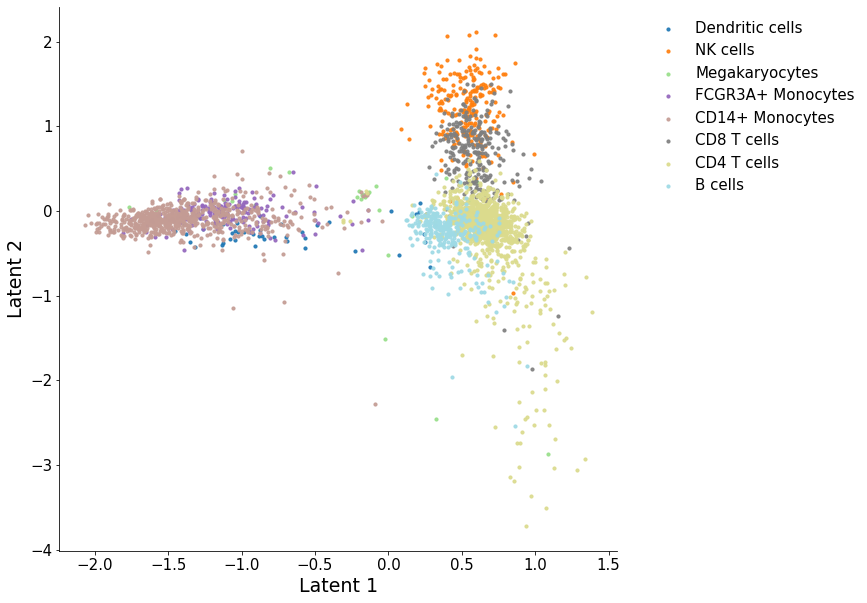

<ipython-input-57-d5cf1b9674ed>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("tab20", len(cluster_types))


VAE.pdf


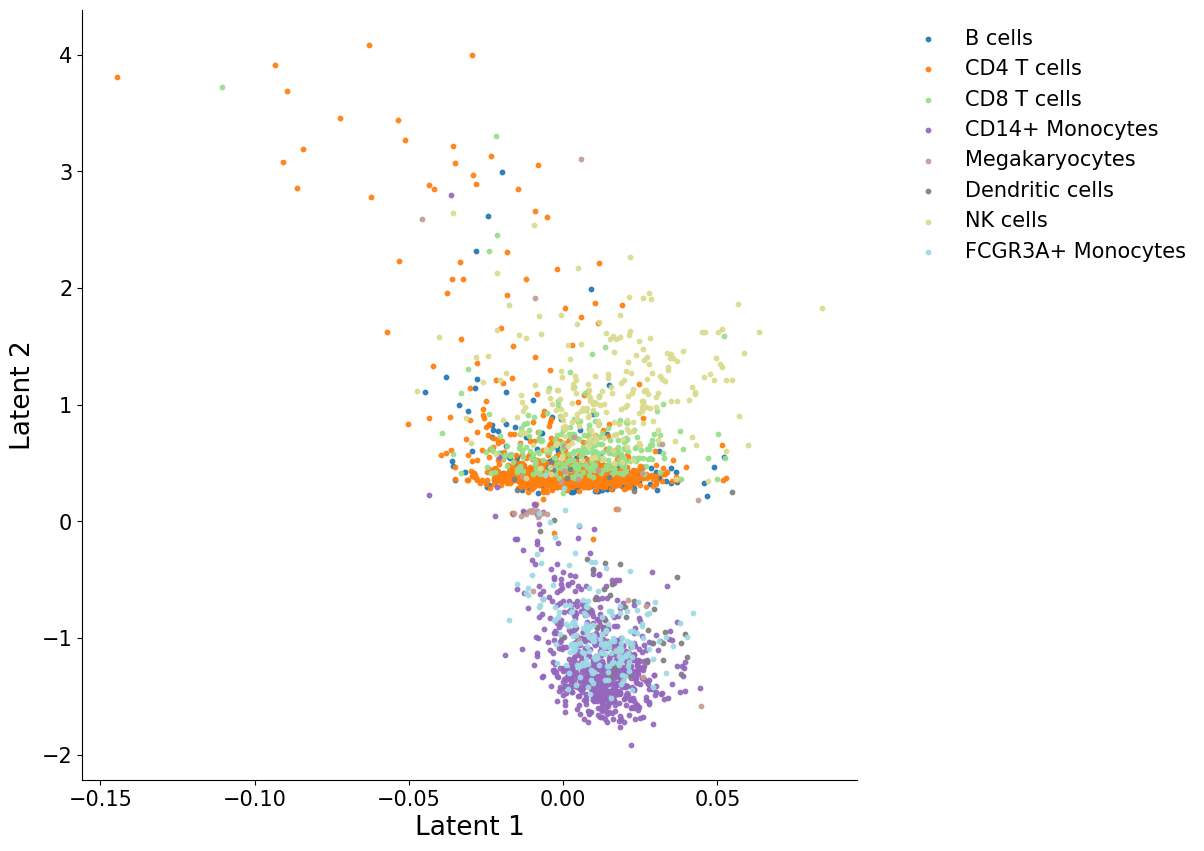

In [ ]:
####################Please don't change this cell.##############################

ae.eval()
with torch.no_grad():
    ae_coordinates = ae(expr_ctrl)
    ae_coordinates = ae_coordinates[1]

plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "VAE.pdf")
####################Please don't change this cell.##############################


## Submission

For this problem, you will need to save the notebook with the outputs and upload it onto gradescope.